In [8]:
import pandas as pd
import seaborn as sns
sns.set()
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus']=False   #这两行需要手动设置
from mpl_toolkits.mplot3d import Axes3D
from keras.layers import LSTM
import numpy as np
np.random.seed(203)
np.set_printoptions(suppress=True)
import warnings
warnings.filterwarnings('ignore')

In [9]:
# 历史入库数据
ruku_data = pd.read_excel('./入库流量数据.xlsx')
ruku_data['TimeStample_cov'] = pd.to_datetime(ruku_data['TimeStample'])

# 环境数据，温度，风速
huanjing_data = pd.read_excel('./环境表.xlsx')
huanjing_data.columns = ['TimeStample','气温','风速','风向']
huanjing_data['TimeStample_cov'] = pd.to_datetime(huanjing_data['TimeStample'])

# 未来5天天气预报,降水量
tianqiyubao_data = pd.read_excel('./降雨预报数据.xlsx')
tianqiyubao_data['TimeStample_cov'] = pd.to_datetime(tianqiyubao_data['TimeStample'])


#遥测站数据
yaocezhan_data = pd.read_excel('./遥测站降雨数据.xlsx')
yaocezhan_data['TimeStample_cov'] = pd.to_datetime(yaocezhan_data['TimeStample'])

<AxesSubplot:xlabel='TimeStample_cov'>

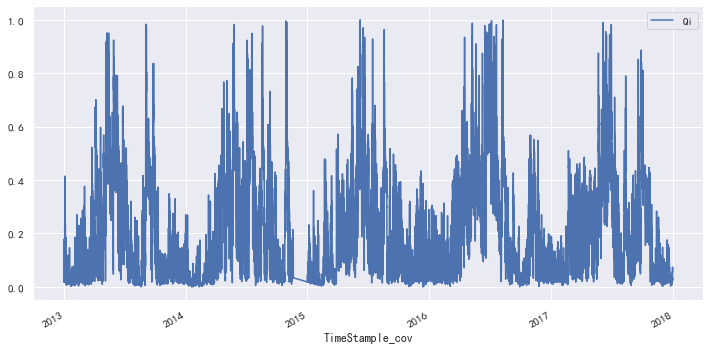

In [10]:
tmpdata = ruku_data[(ruku_data.TimeStample >= '2013-01-01')&(ruku_data.TimeStample < '2018-01-01')]
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False
tmpdata.plot(x='TimeStample_cov',y='Qi',figsize=(12,6))

In [12]:
huanjing_data.head()

,TimeStample,气温,风速,风向,TimeStample_cov
0,2013-01-01,0.168571,0.173913,999012,2013-01-01
1,2013-01-02,0.157143,0.478261,999004,2013-01-02
2,2013-01-03,0.128571,0.717391,999004,2013-01-03
3,2013-01-04,0.037143,0.304348,999003,2013-01-04
4,2013-01-05,0.071429,0.239130,999003,2013-01-05


In [13]:
tianqiyubao_data.head()

,TimeStample,D1,D2,D3,D4,D5,TimeStample_cov
0,2013-03-11,0.0625,0.018182,0.014286,0.10,0.1,2013-03-11
1,2013-03-12,0.1250,0.000000,0.014286,0.20,0.1,2013-03-12
2,2013-03-13,0.0250,0.090909,0.142857,0.10,0.0,2013-03-13
3,2013-03-14,0.0375,0.181818,0.071429,0.00,0.1,2013-03-14
4,2013-03-15,0.1000,0.036364,0.000000,0.16,0.1,2013-03-15


In [14]:
ruku_data[ruku_data.TimeStample<='2018-02-01 23:00:00']

,TimeStample,Qi,TimeStample_cov
0,2013-01-01 02:00:00,0.018201,2013-01-01 02:00:00
1,2013-01-01 05:00:00,0.018196,2013-01-01 05:00:00
2,2013-01-01 08:00:00,0.030095,2013-01-01 08:00:00
3,2013-01-01 11:00:00,0.123196,2013-01-01 11:00:00
4,2013-01-01 14:00:00,0.133178,2013-01-01 14:00:00
...,...,...,...
14518,2018-01-31 11:00:00,0.012904,2018-01-31 11:00:00
14519,2018-01-31 14:00:00,0.083145,2018-01-31 14:00:00
14520,2018-01-31 17:00:00,0.100517,2018-01-31 17:00:00
14521,2018-01-31 20:00:00,0.093789,2018-01-31 20:00:00


In [15]:
create_df = pd.DataFrame()
create_df['TimeStample_cov'] = pd.date_range('2013-01-01 02:00:00', '2018-02-01', freq='3h')
create_df = create_df.merge(ruku_data,how='left',on='TimeStample_cov')
create_df.Qi.fillna(0,inplace=True)

In [16]:
dataset = create_df.Qi.values.reshape(-1, 1)

In [17]:
%matplotlib inline
import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
# let's see the progress bar
from tqdm import tqdm
tqdm().pandas()
import seaborn

0it [00:00, ?it/s]


In [18]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(values, look_back=1):
    '''
    Function to prepare a list of (x, y) data points to data for time series learning
    @param values: (list) list of values 
    @param look_back: (int) number of values for the x list [x1, x2, x3, ... , xn] default 1
    @return _x: x values for the time series
    @return _y: y values for the time series 
    '''
    # set empty lists 
    _x, _y = [], []
    for i in range(len(values)-look_back-1):
        a = values[i:(i+look_back)]      # stack a list of values
        _x.append(a)                        # set x
        _y.append(values[i + look_back]) # set y
    return np.array(_x), np.array(_y)
# fix random seed for reproducibility
np.random.seed(42)

In [19]:
# 分成训练和测试集sets
train_size = int(len(dataset) * 0.8)   # 生成80%的训练数据
train = dataset[:train_size] # 设置训练数据
test  = dataset[train_size:] # 设置测试数据
#重塑为X=t和Y=t+1
look_back = 24
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# 将输入重塑为[示例、时间点、特征]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [20]:
from keras.layers import Conv1D, MaxPooling1D, Dropout
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

def metrics_time_series(y_true, y_pred):
    '''
    Compute the MAE and MSE metrics from sklearn.metrics
    @param y_true: (list) list of the true values
    @param y_pred: (list) list of predicted values
    @return mae, mse: (float), (float) values of metrics MAE and MSE 
    '''
    mae = round(mean_absolute_error(y_true, y_pred), 2)
    mse = round(mean_squared_error(y_true, y_pred), 2)
    print(f"The mean absolute error is: {mae}")
    print(f"The mean squared error is: {mse}")
    return mae, mse

In [21]:
def time_series_deep_learning(x_train, y_train, x_test, y_test, model_dl=LSTM ,  unit=4, look_back=24, cnn=False, bidirection=False, stacked=False):
    '''
    Generate RNN models with different combinations. Can be simple, stacked or bidirectional. Models can also be used with a CNN part. 
    @param x_train: (matrix) x training data with dimension (samples, time steps, features)
    @param y_train: (list) predict data 
    @param x_test: (matrix) x testing data with dimension (samples, time steps, features)
    @param y_test: (list) predict data 
    @param model_dl: (model) rnn type model (LSTM, GRU) default LSTM
    @param unit: (int) number of cells of the RNN default 4
    @param look_back: (int) number of values in x list, configure the shape of the RNN
    @param cnn: (bool) add cnn part of the model default false
    @param bidirection: (bool) add bidirectional model for the RNN default false
    @param stacked: (bool) stacked two layers of RNN models default false
    @return train_predict: (list) predicted values of x_train
    @return train_y: (list) real y values 
    @return test_predict: (list) predicted test values of x_test
    @return test_y: (list) real test values
    @return (dataframe) containing the name of the model and the metrics
    '''
    # Configure an earlystopping callbacks to avoid overfitting
    es = tf.keras.callbacks.EarlyStopping(
        monitor='loss',  patience=5, verbose=0, mode='auto',
    )
    
    # instance of a Sequential model
    model = Sequential()
    
    if cnn: # test if cnn part is needed 
        print("CNN")
        model.add(Conv1D(128, 5, activation='relu'))
        model.add(MaxPooling1D(pool_size=4))
        model.add(Dropout(0.2))
    
    if not bidirection and not stacked: # test if simple model is needed
        print("Simple Model")
        name = model_dl.__name__
        model.add(model_dl(unit,  input_shape=(look_back, 1)))
    elif not bidirection: # test if bidirectional  model is needed
        print("Stacked Model")
        name = "Stacked_"+model_dl.__name__
        model.add(model_dl(unit,  input_shape=(look_back, 1), return_sequences=True))
        model.add(model_dl(unit,  input_shape=(look_back, 1)))
    elif not stacked: # test if stacked models are needed
        print("Bidirectional Model")
        name = "Bi_"+model_dl.__name__
        model.add(Bidirectional(model_dl(unit,  input_shape=(look_back, 1))))
    else: # test if bidirectional and stacked models are needed
        print("Stacked Bidirectional Model")
        name = "Stacked_Bi_"+model_dl.__name__
        model.add(Bidirectional(model_dl(unit,  input_shape=(look_back, 1), return_sequences=True)))
        model.add(Bidirectional(model_dl(unit,  input_shape=(look_back, 1))))
        
    if cnn: # update name with cnn part 
        name = "CNN_"+name
    
    # add Dense layer with one layer and activation function linear to predict continuous values 
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam') # MSE loss but can be replace by 'mean_absolute_error'
    model.fit(trainX, trainY, epochs=1000, batch_size=100, callbacks=[es], verbose=0)
    
    # make predictions
    train_predict = model.predict(x_train)
    test_predict = model.predict(x_test)
    
    # invert predictions
#     train_predict = scaler.inverse_transform(train_predict)
#     train_y = scaler.inverse_transform(y_train)
#     test_predict = scaler.inverse_transform(test_predict)
#     test_y = scaler.inverse_transform(y_test)
    
    # compute the metrics 
    print("Train")
    mae_train, mse_train = metrics_time_series( y_train, train_predict)
    print("Test")
    mae_test, mse_test = metrics_time_series( y_test, test_predict)
    
    return model,train_predict, y_train, test_predict, y_test, pd.DataFrame([name, mae_train, mse_train, mae_test, mse_test], index=["Name", "mae_train", "mse_train", "mae_test", "mse_test"]).T

In [22]:
def plotting_predictions(dataset, look_back, train_predict,  test_predict):
    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
    # shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(train_predict)+(look_back*2)+1:len(dataset)-1, :] = test_predict
    # plot baseline and predictions
    plt.figure(figsize=(20,10))
    plt.plot(dataset[2000:], 'b+--', label="Data")
    plt.plot(trainPredictPlot[2000:], 'g+-', label='Train')
    plt.plot(testPredictPlot[2000:], 'r.--', label="Test")
    #plt.xticks(range(len(dataset[2000:])), np.array(range(len(dataset[2000:])))+2000)
    plt.legend()
    plt.grid(True)
    #plt.savefig("LSTM_predictions.png", dpi=300)
    plt.show()
    

In [23]:
df_results = pd.DataFrame()

Stacked Model
Train
The mean absolute error is: 0.05
The mean squared error is: 0.01
Test
The mean absolute error is: 0.05
The mean squared error is: 0.01


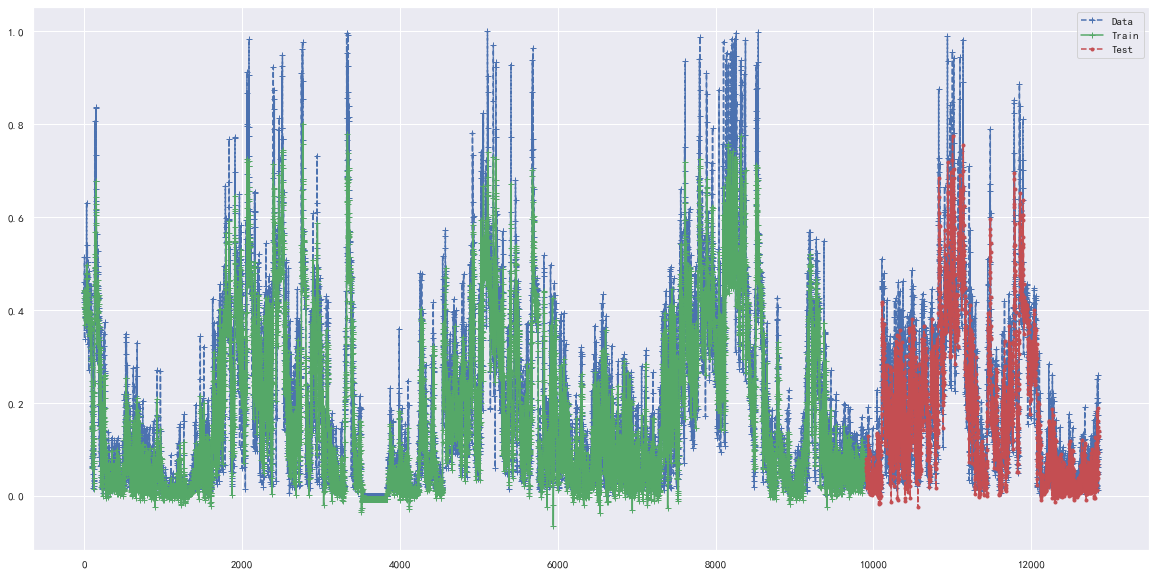

In [17]:
from keras.layers import SimpleRNN
model,x_train_predict_RNN, y_train_RNN,x_test_predict_RNN, y_test_RNN, res= time_series_deep_learning(trainX, trainY, testX, testY, model_dl=SimpleRNN ,  unit=12, look_back=look_back, stacked=True)
plotting_predictions(dataset, look_back, x_train_predict_RNN,  x_test_predict_RNN)
df_results = df_results.append(res)

Stacked Model
Train
The mean absolute error is: 0.05
The mean squared error is: 0.01
Test
The mean absolute error is: 0.05
The mean squared error is: 0.01


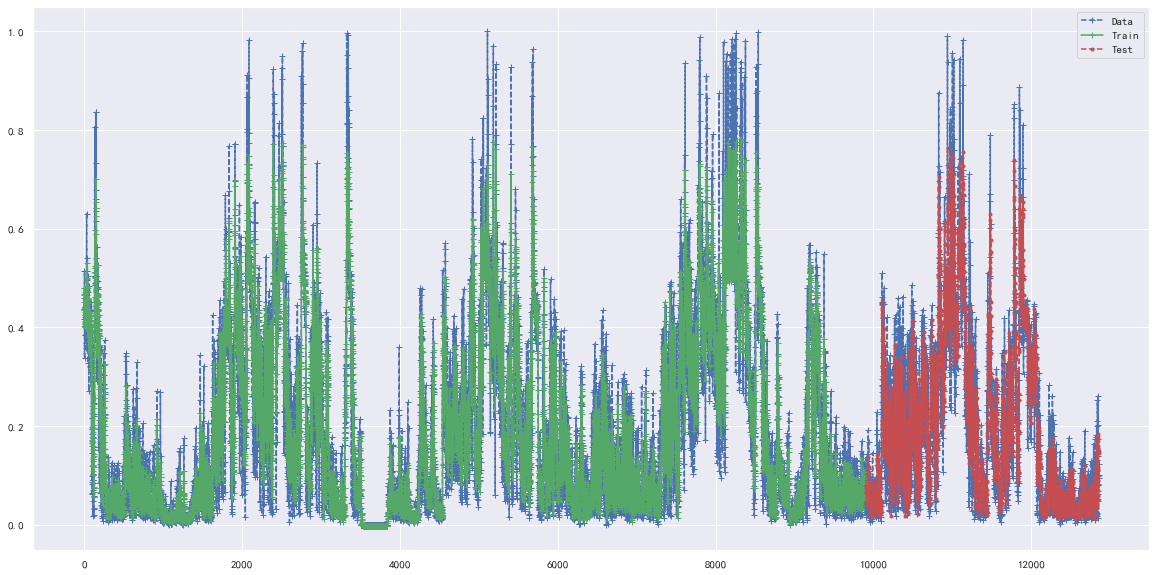

In [21]:
# 堆叠lstm
model,x_train_predict_lstm, y_train_lstm,x_test_predict_lstm, y_test_lstm, res= time_series_deep_learning(trainX, trainY, testX, testY, model_dl=LSTM ,  unit=12, look_back=look_back, stacked=True)
plotting_predictions(dataset, look_back, x_train_predict_lstm,  x_test_predict_lstm)
df_results = df_results.append(res)

In [26]:
first_val = dataset[dataset.shape[0]-look_back:].copy()
for i in range(56):
    tmpval = first_val[i:]
    tmpval = np.reshape(tmpval, (1, 24, 1))
    pred_res = model.predict(tmpval)
    first_val = np.append(first_val, pred_res).reshape(-1,1)
first_val[24:].reshape(-1,)

array([0.09440657, 0.05257347, 0.02929198, 0.04054722, 0.07250349,
       0.10462662, 0.12594712, 0.12674925, 0.10603252, 0.07700568,
       0.05354619, 0.05438077, 0.0756797 , 0.10120159, 0.1196889 ,
       0.12327436, 0.1070763 , 0.08254701, 0.06250105, 0.06123008,
       0.07896946, 0.1005768 , 0.11632432, 0.12000731, 0.10820125,
       0.08688635, 0.06926668, 0.06713761, 0.08029622, 0.09894381,
       0.11336793, 0.11725951, 0.10850441, 0.09134431, 0.07612445,
       0.07301275, 0.0830766 , 0.09881998, 0.11169143, 0.11582027,
       0.10909673, 0.09489498, 0.08169407, 0.07811499, 0.0858332 ,
       0.09910961, 0.11055607, 0.11477906, 0.10971508, 0.09796761,
       0.08654406, 0.08276908, 0.08861832, 0.09979692, 0.10994222,
       0.11412699])

In [28]:
first_val[:24]

array([[0.08289401],
       [0.02199126],
       [0.01702064],
       [0.05025857],
       [0.09127881],
       [0.11788924],
       [0.2520962 ],
       [0.21042326],
       [0.05146357],
       [0.08048401],
       [0.04794899],
       [0.06888588],
       [0.13837425],
       [0.17316865],
       [0.20173721],
       [0.26103329],
       [0.0990611 ],
       [0.08048401],
       [0.06190691],
       [0.01290355],
       [0.08314505],
       [0.10051715],
       [0.09378923],
       [0.12301049]])

Simple Model
Train
The mean absolute error is: 0.05
The mean squared error is: 0.01
Test
The mean absolute error is: 0.05
The mean squared error is: 0.01


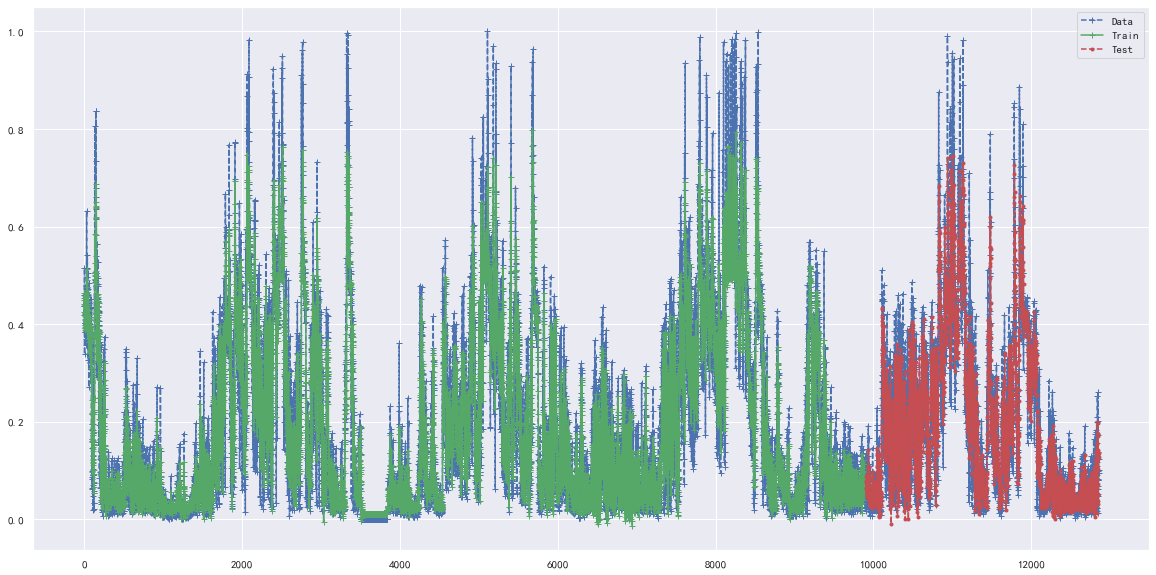

In [67]:
from keras.layers import  GRU
x_train_predict_gru, y_train_gru,x_test_predict_gru, y_test_gru, res= time_series_deep_learning(trainX, trainY, testX, testY, model_dl=GRU ,  unit=12, look_back=24)
plotting_predictions(dataset, look_back, x_train_predict_gru,  x_test_predict_gru)
df_results = df_results.append(res)

Simple Model
Train
The mean absolute error is: 0.06
The mean squared error is: 0.01
Test
The mean absolute error is: 0.06
The mean squared error is: 0.01


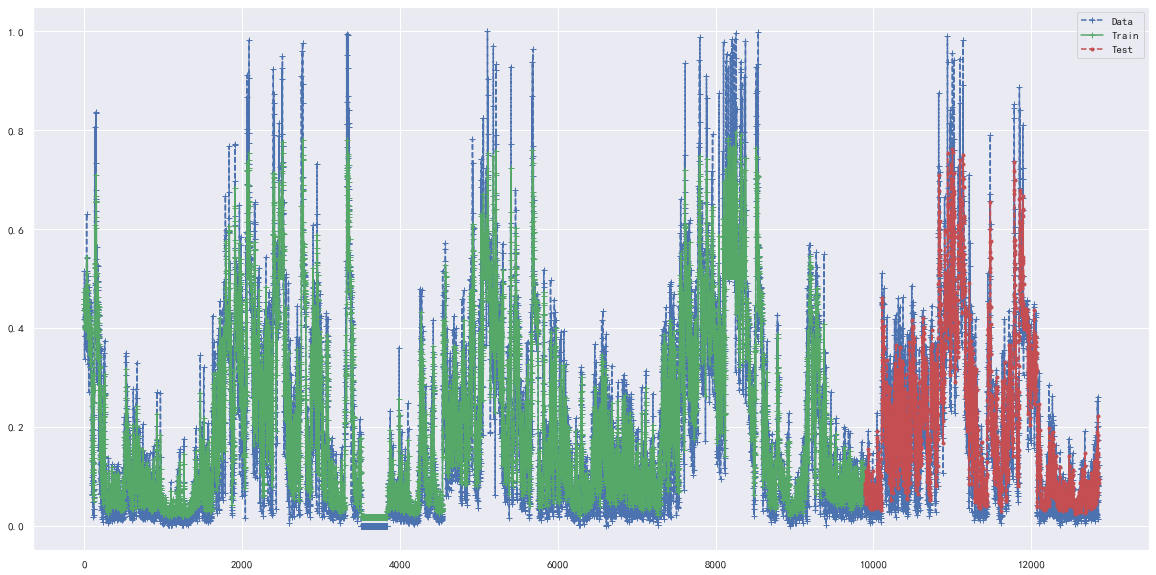

In [40]:
#lsrm
x_train_predict_lstm, y_train_lstm,x_test_predict_lstm, y_test_lstm, res= time_series_deep_learning(trainX, trainY, testX, testY, model_dl=LSTM ,  unit=12, look_back=look_back, stacked=False)
plotting_predictions(dataset, look_back, x_train_predict_lstm,  x_test_predict_lstm)
df_results = df_results.append(res)

Stacked Model
Train
The mean absolute error is: 0.05
The mean squared error is: 0.01
Test
The mean absolute error is: 0.05
The mean squared error is: 0.01


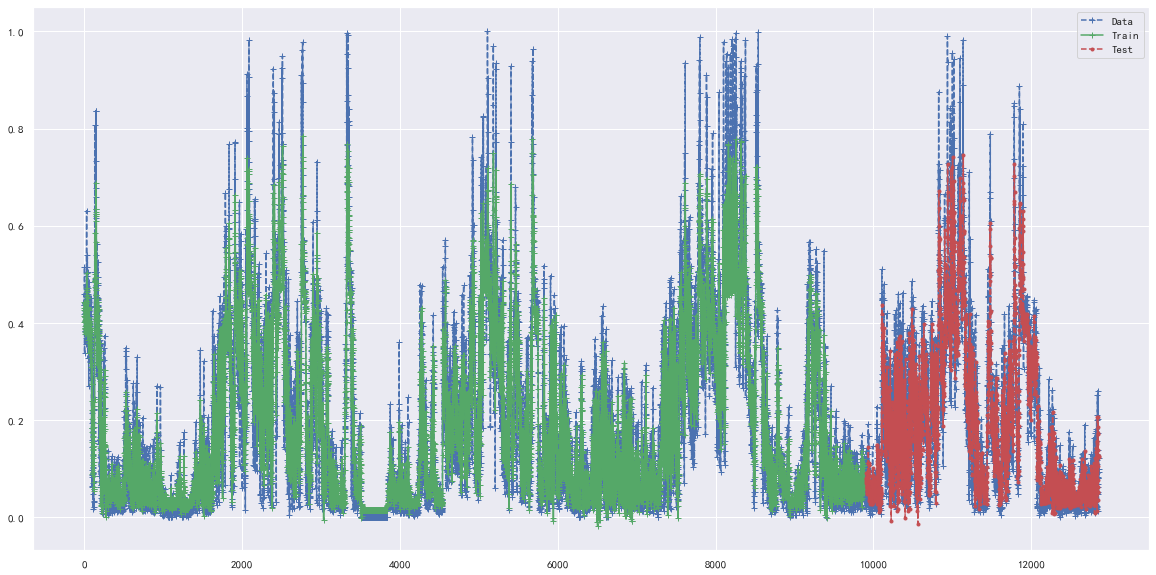

In [69]:
# 堆叠gru
from keras.layers import  GRU
x_train_predict_gru, y_train_gru,x_test_predict_gru, y_test_gru, res= time_series_deep_learning(trainX, trainY, testX, testY, model_dl=GRU ,  unit=12, look_back=24,stacked=True)
plotting_predictions(dataset, look_back, x_train_predict_gru,  x_test_predict_gru)
df_results = df_results.append(res)

Bidirectional Model
Train
The mean absolute error is: 0.06
The mean squared error is: 0.01
Test
The mean absolute error is: 0.06
The mean squared error is: 0.01


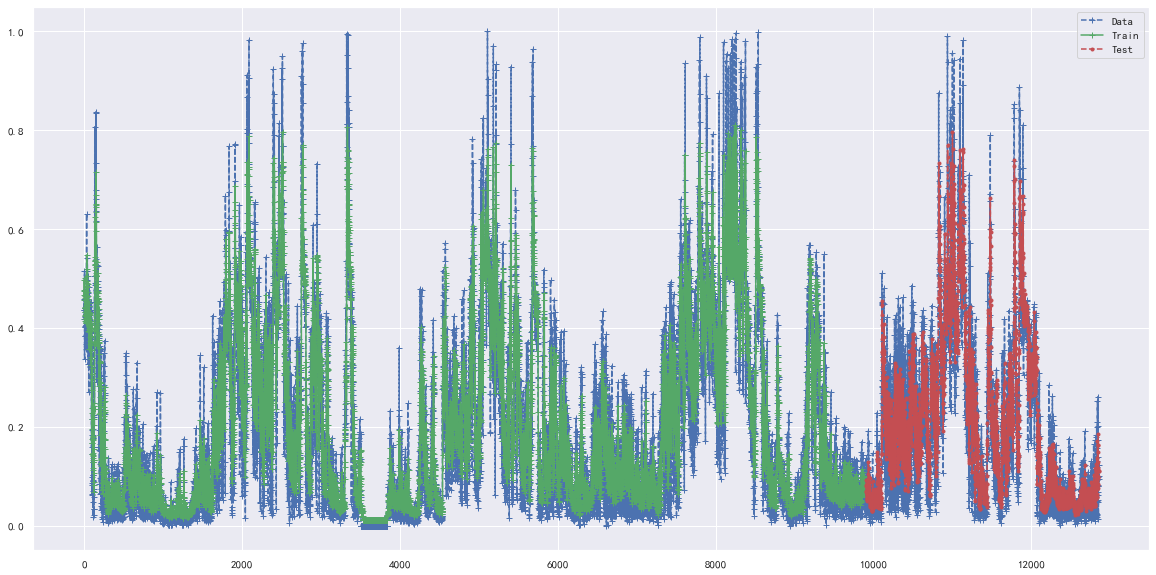

In [73]:
# 双向lstm
from keras.layers import Bidirectional
x_train_predict_bilstm, y_train_bilstm,x_test_predict_bilstm, y_test_bilstm, res= time_series_deep_learning(trainX, trainY, testX, testY, model_dl=LSTM, unit=12, look_back=24,stacked=False,bidirection=True)
plotting_predictions(dataset, look_back, x_train_predict_bilstm,  x_test_predict_bilstm)
df_results = df_results.append(res)

Bidirectional Model
Train
The mean absolute error is: 0.05
The mean squared error is: 0.01
Test
The mean absolute error is: 0.05
The mean squared error is: 0.01


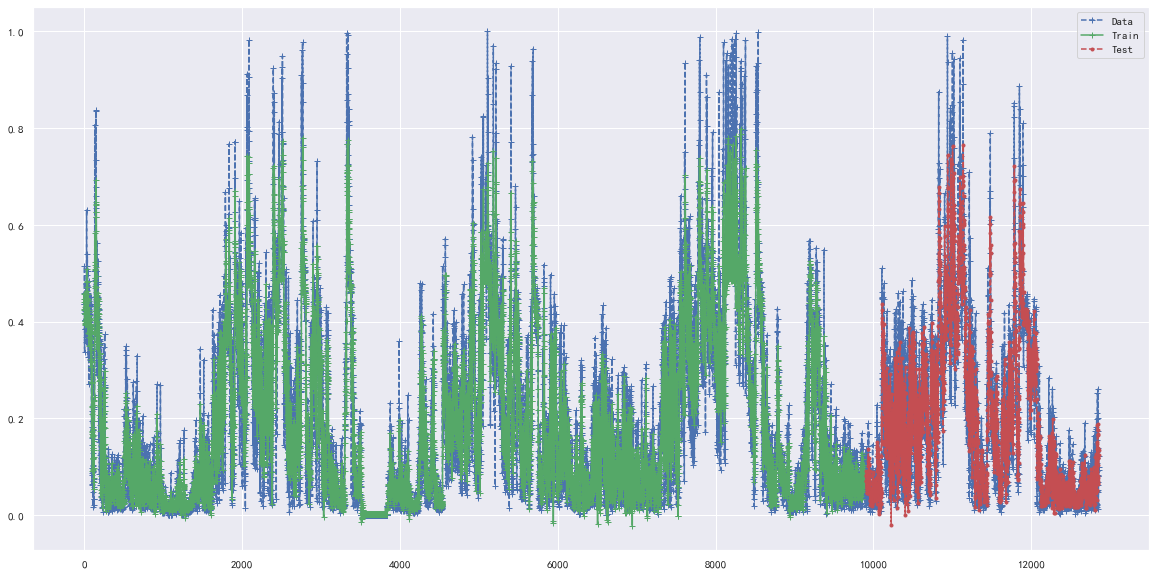

In [74]:
# 双向gru
from keras.layers import  GRU
x_train_predict_gru, y_train_gru,x_test_predict_gru, y_test_gru, res= time_series_deep_learning(trainX, trainY, testX, testY, model_dl=GRU ,  unit=12, look_back=24,stacked=False,bidirection=True)
plotting_predictions(dataset, look_back, x_train_predict_gru,  x_test_predict_gru)
df_results = df_results.append(res)

Stacked Bidirectional Model
Train
The mean absolute error is: 0.06
The mean squared error is: 0.01
Test
The mean absolute error is: 0.05
The mean squared error is: 0.01


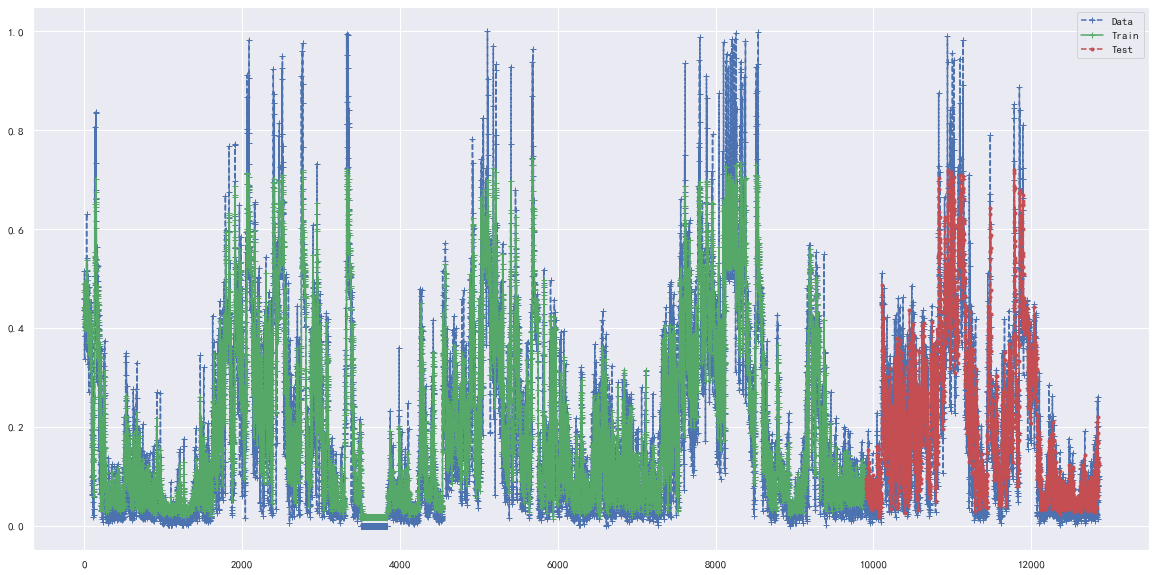

In [25]:
# 堆叠双向lstm
from keras.layers import Bidirectional
model,x_train_predict_bilstm, y_train_bilstm,x_test_predict_bilstm, y_test_bilstm, res= time_series_deep_learning(trainX, trainY, testX, testY, model_dl=LSTM, unit=12, look_back=look_back,stacked=True,bidirection=True)
plotting_predictions(dataset, look_back, x_train_predict_bilstm,  x_test_predict_bilstm)
df_results = df_results.append(res)

In [26]:
first_val = dataset[dataset.shape[0]-look_back:].copy()
for i in range(56):
    tmpval = first_val[i:]
    tmpval = np.reshape(tmpval, (1, 24, 1))
    pred_res = model.predict(tmpval)
    first_val = np.append(first_val, pred_res).reshape(-1,1)

In [27]:
first_val[24:].reshape(-1,)

array([0.10098428, 0.05849774, 0.04657863, 0.06726377, 0.10303759,
       0.11148039, 0.11716282, 0.15546723, 0.11504157, 0.0790109 ,
       0.06491051, 0.08264457, 0.11372003, 0.12513109, 0.12568042,
       0.15710796, 0.14303266, 0.10654569, 0.09267942, 0.10511246,
       0.13304879, 0.14534314, 0.14855856, 0.17138042, 0.15289769,
       0.11272722, 0.10105785, 0.1185107 , 0.14652765, 0.15891394,
       0.16011903, 0.18160608, 0.1663637 , 0.12634443, 0.11259382,
       0.12948269, 0.1573661 , 0.17009091, 0.17108305, 0.1893082 ,
       0.17770575, 0.13750556, 0.12495083, 0.1434112 , 0.17079659,
       0.18124196, 0.18162748, 0.20027165, 0.18743365, 0.14653258,
       0.13428146, 0.15355019, 0.1810295 , 0.19103879, 0.1909356 ,
       0.20832972])

In [28]:
dataset_t = ruku_data[ruku_data.TimeStample<"2018-08-01"].Qi.values.reshape(-1,1)
first_val_t = dataset_t[dataset_t.shape[0]-look_back:].copy()
for i in range(56):
    tmpval = first_val_t[i:]
    tmpval = np.reshape(tmpval, (1, 24, 1))
    pred_res = model.predict(tmpval)
    first_val_t = np.append(first_val_t, pred_res).reshape(-1,1)

In [29]:
first_val_t[24:].reshape(-1,)

array([0.15897346, 0.11625642, 0.13589618, 0.2078499 , 0.23674771,
       0.22010687, 0.26454458, 0.24239275, 0.1645802 , 0.1254641 ,
       0.14411186, 0.20273909, 0.22358826, 0.2072641 , 0.2627959 ,
       0.22965756, 0.14901339, 0.13099641, 0.15209395, 0.19423048,
       0.21276751, 0.20226353, 0.24166746, 0.21593547, 0.15486942,
       0.12693016, 0.15313472, 0.20030375, 0.21237344, 0.20235783,
       0.22763796, 0.22788045, 0.16257332, 0.13896003, 0.16394897,
       0.20440833, 0.21422948, 0.20603545, 0.23170459, 0.22728106,
       0.1674163 , 0.14838432, 0.17275299, 0.20896456, 0.2180673 ,
       0.2116013 , 0.23403771, 0.22767448, 0.17367218, 0.15475678,
       0.17795636, 0.21215411, 0.22145954, 0.21637374, 0.23452361,
       0.23073611])

In [30]:
dataset_s = ruku_data[ruku_data.TimeStample<"2018-11-01"].Qi.values.reshape(-1,1)
first_val_s = dataset_s[dataset_s.shape[0]-look_back:].copy()
for i in range(56):
    tmpval = first_val_s[i:]
    tmpval = np.reshape(tmpval, (1, 24, 1))
    pred_res = model.predict(tmpval)
    first_val_s = np.append(first_val_s, pred_res).reshape(-1,1)

In [31]:
first_val_s[24:].reshape(-1,)

array([0.13013951, 0.1298651 , 0.14556418, 0.16452733, 0.16414252,
       0.15178236, 0.1675598 , 0.1546261 , 0.1163105 , 0.10410625,
       0.12561968, 0.15868884, 0.16753305, 0.16145274, 0.16675225,
       0.19401063, 0.1579527 , 0.15729533, 0.17369425, 0.18617333,
       0.18881211, 0.19554353, 0.20106001, 0.16277249, 0.15506047,
       0.15653007, 0.1758875 , 0.19438751, 0.20025057, 0.20366216,
       0.21196702, 0.19379614, 0.1671761 , 0.16384529, 0.18075712,
       0.19907534, 0.20651159, 0.21053642, 0.21451925, 0.19986412,
       0.1751373 , 0.17710917, 0.19699886, 0.2130079 , 0.21623589,
       0.2218257 , 0.22972441, 0.20617081, 0.1820866 , 0.18187302,
       0.20207323, 0.22014487, 0.2243416 , 0.22786109, 0.23640426,
       0.21811233])

In [34]:
yhat = np.vstack((first_val[24:].reshape(-1,),first_val_t[24:].reshape(-1,),first_val_s[24:].reshape(-1,)))
submit = pd.read_csv('./submission.csv',index_col=0)
for i in range(len(yhat)):
    submit.iloc[i] = yhat[i]
submit.to_csv("./submissiontest.csv")

Stacked Bidirectional Model
Train
The mean absolute error is: 0.05
The mean squared error is: 0.01
Test
The mean absolute error is: 0.05
The mean squared error is: 0.01


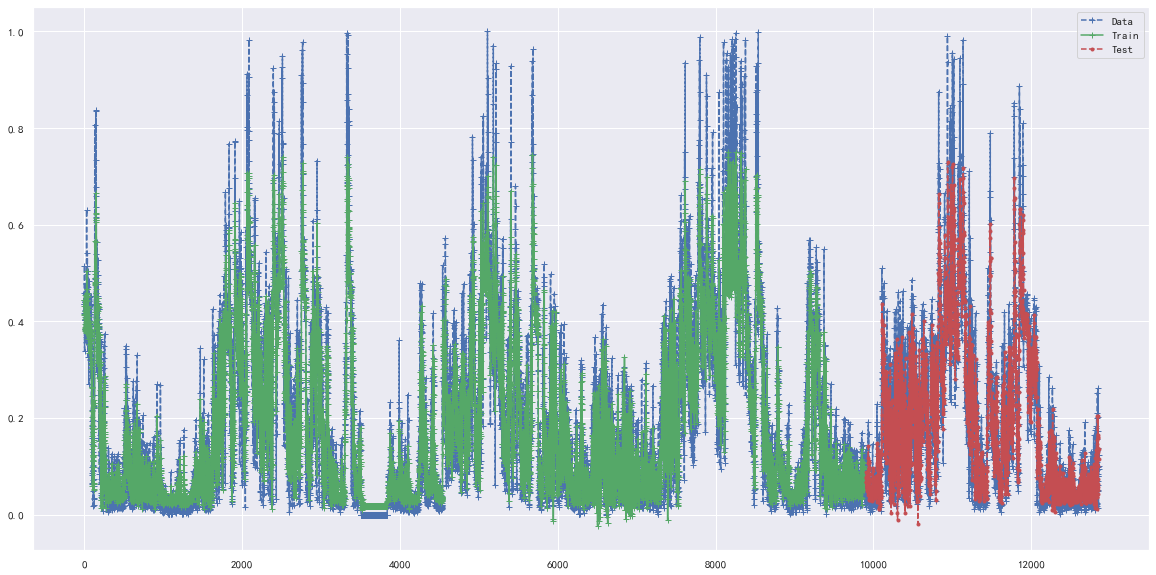

In [76]:
# 堆叠双向gru
from keras.layers import  GRU
x_train_predict_gru, y_train_gru,x_test_predict_gru, y_test_gru, res= time_series_deep_learning(trainX, trainY, testX, testY, model_dl=GRU ,  unit=12, look_back=24,stacked=True,bidirection=True)
plotting_predictions(dataset, look_back, x_train_predict_gru,  x_test_predict_gru)
df_results = df_results.append(res)

CNN
Simple Model
Train
The mean absolute error is: 0.05
The mean squared error is: 0.01
Test
The mean absolute error is: 0.05
The mean squared error is: 0.01


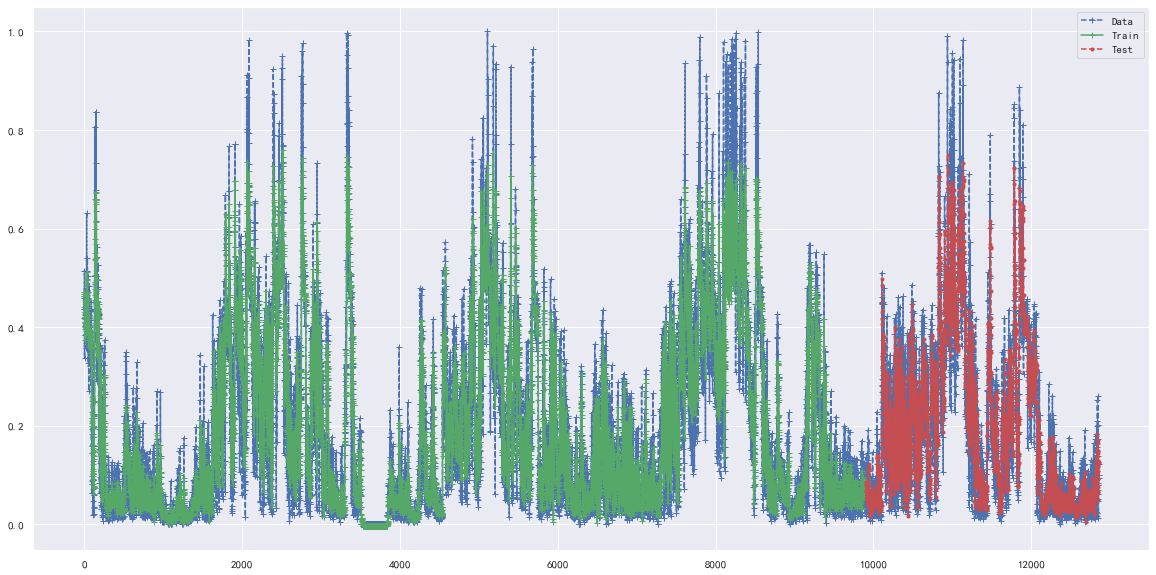

In [32]:
# cnn-lstm
from keras.layers import Bidirectional
model,x_train_predict_bilstm, y_train_bilstm,x_test_predict_bilstm, y_test_bilstm, res= time_series_deep_learning(trainX, trainY, testX, testY, model_dl=LSTM, unit=12, look_back=24,cnn=True)
plotting_predictions(dataset, look_back, x_train_predict_bilstm,  x_test_predict_bilstm)
df_results = df_results.append(res)

In [33]:
first_val = dataset[dataset.shape[0]-look_back:].copy()
for i in range(56):
    tmpval = first_val[i:]
    tmpval = np.reshape(tmpval, (1, 24, 1))
    pred_res = model.predict(tmpval)
    first_val = np.append(first_val, pred_res).reshape(-1,1)
first_val[24:].reshape(-1,)

array([0.08846296, 0.06069819, 0.0423236 , 0.04782095, 0.09611967,
       0.09960085, 0.09856084, 0.10662429, 0.08996505, 0.06705143,
       0.06114319, 0.06998068, 0.08938462, 0.08774713, 0.08308287,
       0.08680727, 0.07669695, 0.06523483, 0.06232202, 0.06618847,
       0.07259327, 0.06863361, 0.06577776, 0.06702268, 0.06315735,
       0.05828606, 0.05752364, 0.0588122 , 0.06034934, 0.05830075,
       0.05678755, 0.05683456, 0.05516861, 0.05373011, 0.05336788,
       0.05345321, 0.05363505, 0.05274896, 0.05206809, 0.0519245 ,
       0.05124644, 0.05080196, 0.05052935, 0.05041452, 0.0503317 ,
       0.04995644, 0.04963847, 0.04950358, 0.04921841, 0.04907166,
       0.04891044, 0.0487968 , 0.04869522, 0.04853167, 0.04839281,
       0.04831081])

In [34]:
dataset_t = ruku_data[ruku_data.TimeStample<"2018-08-01"].Qi.values.reshape(-1,1)
first_val_t = dataset_t[dataset_t.shape[0]-look_back:].copy()
for i in range(56):
    tmpval = first_val_t[i:]
    tmpval = np.reshape(tmpval, (1, 24, 1))
    pred_res = model.predict(tmpval)
    first_val_t = np.append(first_val_t, pred_res).reshape(-1,1)

In [35]:
dataset_s = ruku_data[ruku_data.TimeStample<"2018-11-01"].Qi.values.reshape(-1,1)
first_val_s = dataset_s[dataset_s.shape[0]-look_back:].copy()
for i in range(56):
    tmpval = first_val_s[i:]
    tmpval = np.reshape(tmpval, (1, 24, 1))
    pred_res = model.predict(tmpval)
    first_val_s = np.append(first_val_s, pred_res).reshape(-1,1)

In [36]:
yhat = np.vstack((first_val[24:,0],first_val_t[24:,0],first_val_s[24:,0]))

In [37]:
submit = pd.read_csv('./submission.csv',index_col=0)
for i in range(len(yhat)):
    submit.iloc[i] = yhat[i]
submit.to_csv("./submissiontest.csv")

CNN
Simple Model
Train
The mean absolute error is: 0.05
The mean squared error is: 0.01
Test
The mean absolute error is: 0.05
The mean squared error is: 0.01


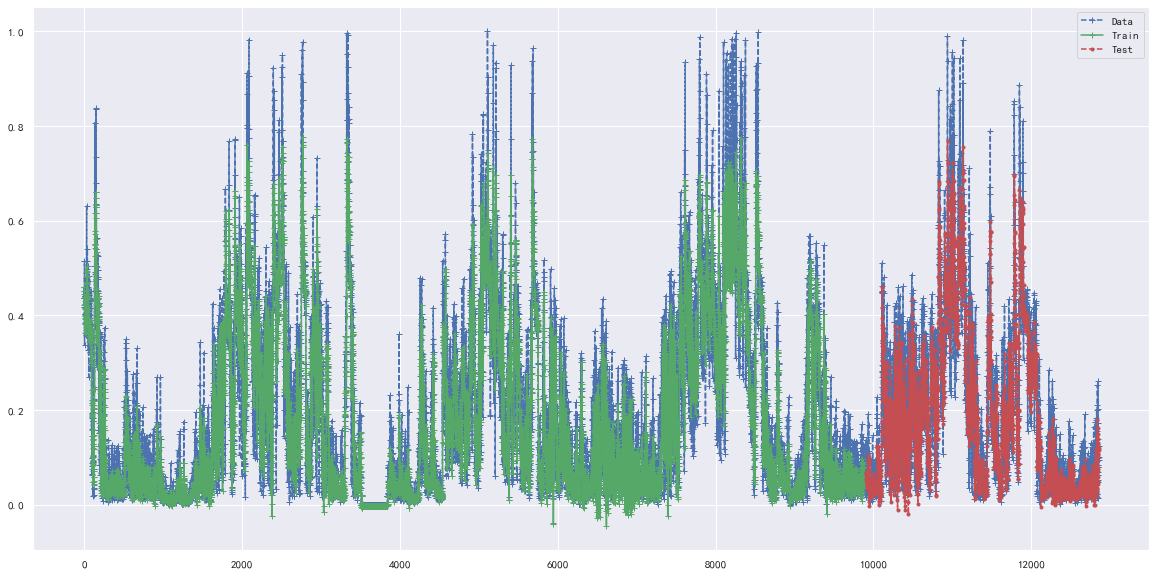

In [78]:
# cnn-gru
from keras.layers import  GRU
x_train_predict_gru, y_train_gru,x_test_predict_gru, y_test_gru, res= time_series_deep_learning(trainX, trainY, testX, testY, model_dl=GRU ,  unit=12, look_back=24,cnn=True)
plotting_predictions(dataset, look_back, x_train_predict_gru,  x_test_predict_gru)
df_results = df_results.append(res)

In [79]:
df_results

,Name,mae_train,mse_train,mae_test,mse_test
0,Stacked_SimpleRNN,0.05,0.01,0.05,0.01
0,Stacked_LSTM,0.06,0.01,0.06,0.01
0,SimpleRNN,0.05,0.01,0.05,0.01
0,LSTM,0.06,0.01,0.06,0.01
0,Stacked_LSTM,0.05,0.01,0.05,0.01
0,Stacked_SimpleRNN,0.05,0.01,0.05,0.01
0,GRU,0.05,0.01,0.05,0.01
0,LSTM,0.06,0.01,0.06,0.01
0,Stacked_GRU,0.05,0.01,0.05,0.01
0,Bi_LSTM,0.06,0.01,0.06,0.01
